# 视觉里程计
学号：23103402  
姓名：丁悦林

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import bisect
import pandas as pd
from scipy.spatial.transform import Rotation as R

In [28]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## RGB ORB 单目VO

根据txt文件中的描述“rgbd_dataset_freiburg2_desk.bag”，应该是属于tum数据集的freiburg2系列。

所以使用tum数据集fr2系列的参数。

In [29]:
# tum数据集fr2系列
# 相机内参
K = np.array([[520.9, 0.0, 325.1],
              [0.0, 521.0, 249.7],
              [0.0, 0.0, 1.0]])

# 畸变系数[k1, k2, p1, p2, k3]
dist_coef = np.array([0.2312, -0.7849, -0.0033, -0.0001, 0.9172])

In [30]:
def load_images_from_tum(path):
    """
    读取tum数据集的 rgb.txt 文件，解析文件名并排序
    """
    rgb_txt_path = os.path.join(path, 'rgb.txt')
    image_files = []
    timestamps = []
    
    if not os.path.exists(rgb_txt_path):
        print(f"Error: {rgb_txt_path} not found.")
        return [], []
        
    with open(rgb_txt_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split()
            if len(parts) >= 2:
                timestamp = float(parts[0]) # 时间戳
                filename = os.path.join(path, parts[1]) # 文件路径
                timestamps.append(timestamp)
                image_files.append(filename)
    
    return image_files, timestamps

In [31]:
dataset_path = "../data/chaoxing_data/tum"
images, times = load_images_from_tum(dataset_path)
print(f"共加载了 {len(images)} 帧图像")

共加载了 2965 帧图像


In [32]:
def detect_features(img):
    """
    使用 ORB 提取特征点和描述子
    """
    orb = cv2.ORB_create(nfeatures=3000) # 提取3000个特征点，保证鲁棒性
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def match_features(des1, des2):
    """
    使用 BFMatcher 进行特征匹配，并使用 Lowe's Ratio Test 过滤
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance: # 0.75 是常用的阈值
            good_matches.append(m)
            
    return good_matches

def estimate_motion(kp1, kp2, matches, K):
    """
    计算两帧之间的位姿变化 (R, t)
    """
    # 提取匹配点的坐标
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # 1. 计算本征矩阵 E (使用 cv2.RANSAC)
    E, mask = cv2.findEssentialMat(pts2, pts1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    if E is None or E.shape != (3, 3):
        return None, None, None
        
    # 2. 从本征矩阵恢复位姿 R, t
    _, R, t, mask_pose = cv2.recoverPose(E, pts2, pts1, K)
    
    return R, t, mask

In [33]:
# VO 主循环(添加畸变校正)

def run_mono_vo(images, K, dist_coef):
    # 定义相机在世界坐标系的初始位置和姿态
    cur_R = np.eye(3) # 单位矩阵
    cur_t = np.zeros((3, 1))
    
    trajectory = [] # 存储 [x, y, z]
    trajectory.append(cur_t.flatten())
    
    # === 读取第一帧 ===
    prev_img = cv2.imread(images[0])
    if prev_img is None:
        raise ValueError("无法读取第一帧图像")
        
    # 畸变校正
    # 注意：newCameraMatrix=K 保证校正后的图像仍符合原来的内参 K，这样后续 estimate_motion 时可以直接使用 K
    prev_img = cv2.undistort(prev_img, K, dist_coef, None, K)
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    
    # 提取第一帧特征
    prev_kp, prev_des = detect_features(prev_gray)
    
    print("开始处理图像序列，已启用畸变校正...")
    
    # === 循环处理后续帧 ===
    for i in range(1, len(images)):
        curr_img = cv2.imread(images[i])
        
        # 畸变校正 (当前帧)
        curr_img = cv2.undistort(curr_img, K, dist_coef, None, K)
        curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        
        # 1. 特征提取
        curr_kp, curr_des = detect_features(curr_gray)
        
        # 2. 特征匹配
        if prev_des is None or curr_des is None:
            continue
        matches = match_features(prev_des, curr_des)
        
        # 3. 运动估计
        if len(matches) < 8: # 8点法求解E矩阵的最低要求
            continue
            
        R, t, mask = estimate_motion(prev_kp, curr_kp, matches, K)
        
        if R is not None:
            # 这里的 absolute_scale = 1.0 假设每一帧相机移动距离恒定
            # 这会导致轨迹比例尺不符实际
            absolute_scale = 1.0 
            
            # 简单的防抖动处理
            if absolute_scale > 0.1: 
                # 更新全局位姿
                cur_t += absolute_scale * cur_R.dot(t)
                cur_R = cur_R.dot(R)
                
            trajectory.append(cur_t.flatten()) # trajectory里面存储位移向量[x, y, z]
            
        # 更新上一帧数据
        prev_gray = curr_gray
        prev_kp = curr_kp
        prev_des = curr_des
        
        # 打印进度
        if i % 50 == 0:
            print(f"Processing frame {i}/{len(images)} ...")
            
    return np.array(trajectory)

In [71]:
traj_est = run_mono_vo(images[:600], K, dist_coef)
print("处理完成。")

开始处理图像序列，已启用畸变校正...
Processing frame 50/300 ...
Processing frame 100/300 ...
Processing frame 150/300 ...
Processing frame 200/300 ...
Processing frame 250/300 ...
处理完成。


In [72]:
# 结果可视化

def plot_trajectory(traj):
    # TODO：吧GroundTruth也画出来
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # traj 的形状是 (N, 3)，分别是 x, y, z
    x = traj[:, 0]
    z = traj[:, 2] # 也是前进方向
    
    ax.plot(x, z, label='估计的轨迹 (单目)', color='blue', linewidth=2, alpha=0.7)
    ax.scatter(x[0], z[0], color='red', s=80, label='起点')  # s为点的大小
    
    ax.set_title(f'单目视觉里程计轨迹(X-Z平面，前{len(traj)}帧)', fontsize=16)
    ax.set_xlabel('X (米) - 比例任意', fontsize=12)
    ax.set_ylabel('Z (米) - 比例任意', fontsize=12)
    ax.legend()
    ax.axis('equal') # 保证比例一致，否则形状会变形
    plt.show()

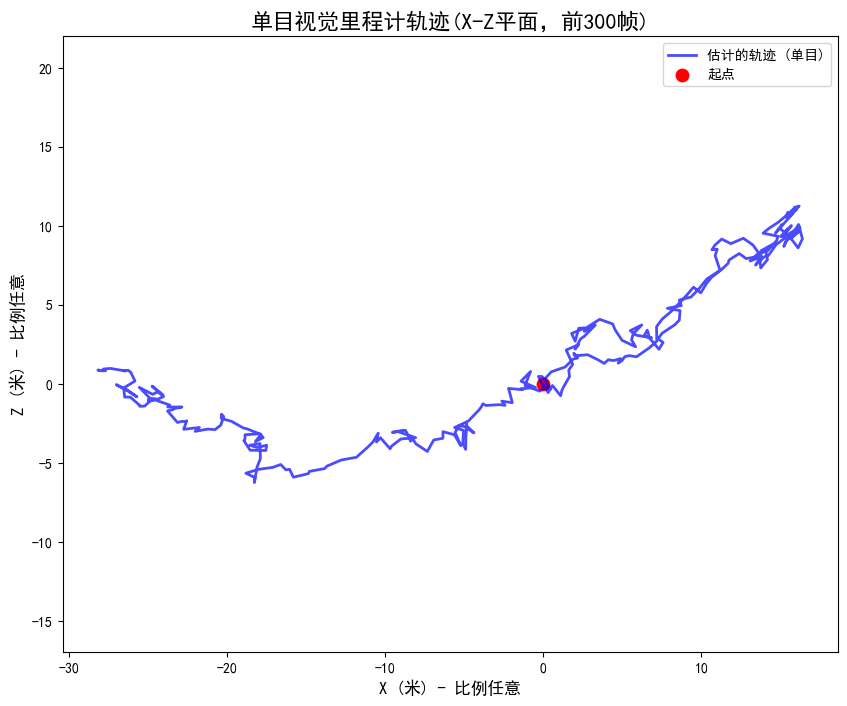

In [73]:
# TODO：实验一的结果存疑；需要把终点也画出来
if len(traj_est) > 0:
    plot_trajectory(traj_est)
else:
    print("没有生成有效的轨迹。")

## RGB->GT 数据关联

In [37]:
# Cell 6: 读取 Ground Truth 数据 --修复版

# def load_groundtruth(dataset_path):
#     """
#     读取 groundtruth.txt 文件
#     返回: 
#         gt_data: 字典 {timestamp: [tx, ty, tz, qx, qy, qz, qw]} 
#         gt_timestamps: 时间戳列表
#     """
#     gt_path = os.path.join(dataset_path, 'groundtruth.txt')
    
#     gt_data = {}
#     gt_timestamps = []
    
#     if not os.path.exists(gt_path):
#         print(f"Error: {gt_path} not found.")
#         return {}, []
    
#     print(f"正在读取 Ground Truth: {gt_path}")
#     with open(gt_path, 'r') as f:
#         for line in f:
#             if line.startswith('#'): continue
#             parts = line.strip().split()
#             if len(parts) >= 8:
#                 t = float(parts[0])
#                 # 提取 tx, ty, tz, qx, qy, qz, qw
#                 data = np.array([float(x) for x in parts[1:8]])
#                 gt_data[t] = data
#                 gt_timestamps.append(t)
    
#     gt_timestamps.sort() # 二分查找必须有序
#     print(f"加载了 {len(gt_timestamps)} 条 Ground Truth 记录")
#     return gt_data, gt_timestamps
def load_groundtruth(dataset_path):
    """
    读取 groundtruth.txt 文件
    返回: 
        gt_data: 字典 {timestamp: [tx, ty, tz, qx, qy, qz, qw]} 
        gt_timestamps: 时间戳列表
    """
    gt_path = os.path.join(dataset_path, 'groundtruth.txt')
    gt_data = {}
    gt_timestamps = []
    if not os.path.exists(gt_path): return {}, []
    
    print(f"正在读取 Ground Truth: {gt_path}")
    with open(gt_path, 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.strip().split()
            if len(parts) >= 8:
                t = float(parts[0])
                # 提取[tx, ty, tz, qx, qy, qz, qw]
                gt_data[t] = np.array([float(x) for x in parts[1:8]])
                gt_timestamps.append(t)
    gt_timestamps.sort()
    print(f"GT 加载完成，共 {len(gt_timestamps)} 帧")
    return gt_data, gt_timestamps

In [38]:
gt_dict, gt_times_list = load_groundtruth(dataset_path)

正在读取 Ground Truth: ../data/chaoxing_data/tum\groundtruth.txt
GT 加载完成，共 20957 帧


In [39]:
# Cell 7: 时间戳同步

# def find_nearest_timestamp(target_time, sorted_times):
#     """
#     在有序列表 sorted_times 中找到与 target_time 最接近的时间戳
#     使用 bisect 二分查找
#     """
#     idx = bisect.bisect_left(sorted_times, target_time)
    
#     # idx 是插入位置，可能的最近邻是 idx 或 idx-1
#     if idx == 0:
#         return sorted_times[0]
#     if idx == len(sorted_times):
#         return sorted_times[-1]
    
#     before = sorted_times[idx - 1]
#     after = sorted_times[idx]
    
#     if after - target_time < target_time - before:
#         return after
#     else:
#         return before
def find_nearest_timestamp(target_time, sorted_times):
    """
    在有序列表 sorted_times 中找到与 target_time 最接近的时间戳
    使用 bisect 二分查找
    """
    idx = bisect.bisect_left(sorted_times, target_time)
    # idx 是插入位置，可能的最近邻是 idx 或 idx-1
    if idx == 0: return sorted_times[0]
    if idx == len(sorted_times): return sorted_times[-1]
    
    before = sorted_times[idx - 1]
    after = sorted_times[idx]
    return after if (after - target_time < target_time - before) else before

def associate_data(est_timestamps, est_traj, gt_dict, gt_times_list, max_time_diff=0.02):
    """
    将估算轨迹与 GT 进行时间对齐
    """
    matched_data = []
    
    # 确保估算数据的长度一致
    assert len(est_timestamps) == len(est_traj), "时间戳与轨迹点数量不匹配"
    
    print(f"开始对齐 {len(est_timestamps)} 帧估算数据...")
    
    for i, t_rgb in enumerate(est_timestamps):
        # 1. 寻找最近的 GT 时间戳
        t_gt = find_nearest_timestamp(t_rgb, gt_times_list) # 二分查找
        
        # 2. 计算时间差
        diff = abs(t_rgb - t_gt)
        
        # 3. 阈值判定 (通常 0.02s 内认为匹配成功)
        if diff < max_time_diff:
            # 提取数据
            est_pos = est_traj[i] # [x, y, z] 估算值
            gt_pos = gt_dict[t_gt] # [x, y, z] 真值
            
            # 构建一行数据
            # 格式: [rgb_time, est_x, est_y, est_z, gt_time, gt_x, gt_y, gt_z]
            row = {
                'timestamp_rgb': t_rgb,
                'est_x': est_pos[0],
                'est_y': est_pos[1],
                'est_z': est_pos[2],
                'timestamp_gt': t_gt,
                'gt_x': gt_pos[0],
                'gt_y': gt_pos[1],
                'gt_z': gt_pos[2],
                'time_diff': diff
            }
            matched_data.append(row)
            
    print(f"匹配成功: {len(matched_data)} / {len(est_timestamps)} 帧")
    return pd.DataFrame(matched_data)

In [40]:
# === 执行对齐 ===
# times 是所有图片的时间戳，需要切片前 len(traj_est) 个
# 之前跑的是 images[:600]，那么 traj_est 长度就是 600，对应times[:600]

current_est_timestamps = times[:len(traj_est)]
df_matched = associate_data(current_est_timestamps, traj_est, gt_dict, gt_times_list)

df_matched.head()

开始对齐 500 帧估算数据...
匹配成功: 450 / 500 帧


,timestamp_rgb,est_x,est_y,est_z,timestamp_gt,gt_x,gt_y,gt_z,time_diff
0,1.311868e+09,0.000000,0.000000,0.000000,1.311868e+09,-0.1546,-1.4445,1.4773,0.000019
1,1.311868e+09,0.307506,-0.793291,-0.525480,1.311868e+09,-0.1578,-1.4458,1.4770,0.000774
2,1.311868e+09,0.582658,-1.644854,-0.079239,1.311868e+09,-0.1601,-1.4472,1.4767,0.001140
3,1.311868e+09,1.098858,-2.202891,-0.728955,1.311868e+09,-0.1633,-1.4501,1.4766,0.000145
4,1.311868e+09,1.176567,-3.137807,-0.382699,1.311868e+09,-0.1660,-1.4525,1.4765,0.000670


In [41]:
# Cell 8: 保存对齐结果到 CSV

output_csv_name = 'tum_rgb_to_gt.csv'
if not df_matched.empty:
    # 列头
    cols_to_save = ['timestamp_rgb', 'est_x', 'est_y', 'est_z', 'timestamp_gt',
                    'gt_x', 'gt_y', 'gt_z', 'time_diff']
    
    df_matched[cols_to_save].to_csv(output_csv_name, index=False)
    print(f"RGB->GT数据对齐已保存至: {os.path.abspath(output_csv_name)}")

RGB->GT数据对齐已保存至: e:\Python_Project\camera_calibrate\Camera_Calibrate\code\tum_rgb_to_gt.csv


## RGB 光流 单目VO

In [42]:
# Cell 9: 配置光流法参数

# Lucas-Kanade 光流参数
lk_params = dict(winSize  = (21, 21), # 搜索窗口大小，越大越能适应大幅度运动，但精度可能下降
                 maxLevel = 3, # 金字塔层数，解决大位移问题
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

# 特征提取参数 (GFTT)
feature_params = dict(maxCorners = 3000,       # 最大特征点数
                      qualityLevel = 0.01,     # 角点质量
                      minDistance = 7,         # 特征点最小间距
                      blockSize = 7)

# TODO：这个是什么函数？简化了？
def feature_tracking(image, prev_pts):
    """
    对当前帧进行光流追踪
    如果是第一帧或者点不够了，需要外部调用 detect 重新检测
    """
    # 这一步仅做追踪，不检测
    pass

In [43]:
# Cell 10: 基于光流法的单目 VO 主循环

def run_optical_flow_vo(images, K, dist_coef):
    # === 初始化 ===
    cur_R = np.eye(3)
    cur_t = np.zeros((3, 1))
    trajectory = [cur_t.flatten()]
    
    # 读取第一帧并去畸变
    prev_img = cv2.imread(images[0])
    prev_img = cv2.undistort(prev_img, K, dist_coef, None, K)
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    
    # 初始特征提取 (GFTT)
    # prev_pts 的形状应该是 (N, 1, 2)，这是 OpenCV 光流函数的标准输入格式
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
    print(f"开始光流法追踪，初始特征点数: {len(prev_pts)}")
    
    # === 主循环 ===
    for i in range(1, len(images)):
        curr_img = cv2.imread(images[i])
        curr_img = cv2.undistort(curr_img, K, dist_coef, None, K) # 必须去畸变
        curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        
        # 1. 光流追踪 (计算 prev_pts 在 curr_gray 中的位置)
        # curr_pts: 当前帧位置, status: 1找到/0未找到, err: 误差
        curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
        # 2. 筛选有效点：选取 status==1 的点
        good_new = curr_pts[status == 1]
        good_old = prev_pts[status == 1]
        
        # 3. 位姿估计 (本征矩阵 E)
        if len(good_new) < 8: # 点太少，无法计算
            print(f"Frame {i}: Tracking lost (points < 8).")
            # 这种情况下通常应该重置，但为了实验简单，我们跳过更新，直接补充特征
            pass 
        else:
            # 计算 E, 注意需要将点转换为 float32 且符合 shape 要求
            E, mask = cv2.findEssentialMat(good_new, good_old, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
            
            if E is not None:
                _, R, t, mask_pose = cv2.recoverPose(E, good_new, good_old, K)
                
                # 更新位姿 (同样假设 scale = 1.0)
                absolute_scale = 1.0
                
                if absolute_scale > 0.1:
                    cur_t = cur_t + absolute_scale * cur_R.dot(t)
                    cur_R = cur_R.dot(R)
                
                trajectory.append(cur_t.flatten())
        
        # 4. 特征点补充
        # 如果跟踪点少于阈值，重新检测特征点
        # 这里的策略是：如果点太少，就重新在整张图检测新的，以此作为下一帧的起点
        if len(good_new) < 1500: # 阈值可调
            # 重新检测特征点
            new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
            prev_pts = new_pts
        else:
            # 如果点还够多，继续跟踪现有的点
            prev_pts = good_new.reshape(-1, 1, 2)
            
        # 更新上一帧图像
        prev_gray = curr_gray
        
        # 打印进度
        if i % 50 == 0:
            print(f"Processing {i}/{len(images)}, Tracked points: {len(good_new)}")
            
    return np.array(trajectory)

In [44]:
# 运行实验三 (使用前600帧进行快速验证，也可以跑全量)
traj_est_optflow = run_optical_flow_vo(images[:600], K, dist_coef)
print("光流法 VO 完成。")

开始光流法追踪，初始特征点数: 440
Processing 50/500, Tracked points: 355
Processing 100/500, Tracked points: 382
Processing 150/500, Tracked points: 420
Processing 200/500, Tracked points: 545
Processing 250/500, Tracked points: 421
Processing 300/500, Tracked points: 489
Processing 350/500, Tracked points: 517
Processing 400/500, Tracked points: 530
Processing 450/500, Tracked points: 426
光流法 VO 完成。


In [45]:
# Cell 11: 轨迹对比

def plot_comparison(traj_orb, traj_flow):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # ORB
    ax.plot(traj_orb[:, 0], traj_orb[:, 2], label='ORB算法', 
            color='blue', linewidth=2, linestyle='--',alpha=0.7)
    # 光流
    ax.plot(traj_flow[:, 0], traj_flow[:, 2], label='光流算法', 
            color='red', linewidth=2,alpha=0.7)
    
    ax.scatter(traj_orb[0, 0], traj_orb[0, 2], color='black', s=80, label='ORB 起点')
    ax.scatter(traj_flow[0, 0], traj_flow[0, 2], color='black', s=80, label='光流 起点')
    
    ax.set_title('轨迹对比: ORB vs 光流', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Z (m)', fontsize=12)
    ax.legend()
    ax.axis('equal')
    plt.show()

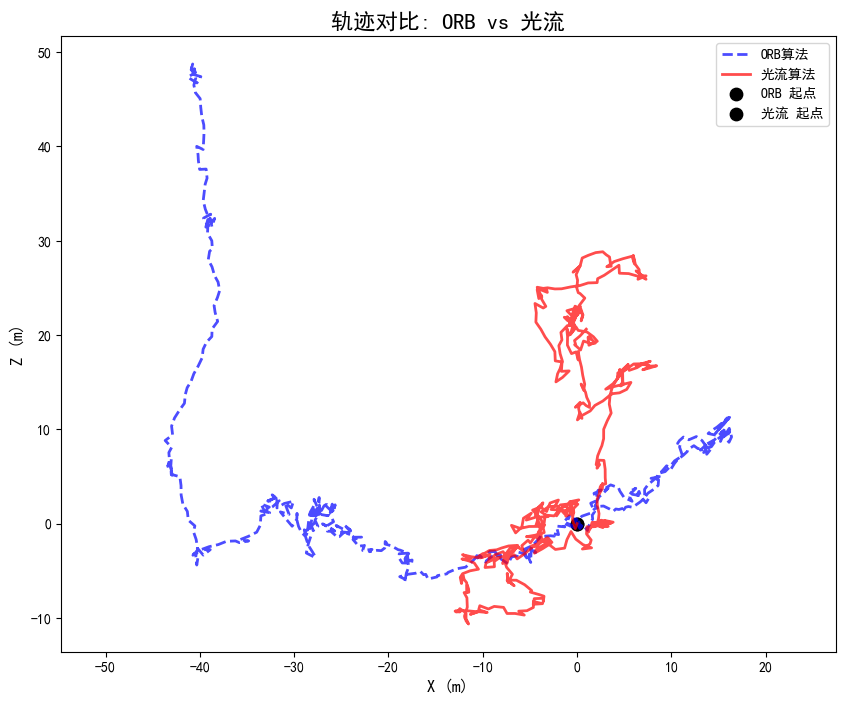

In [46]:
if len(traj_est_optflow) > 0:
    # traj_est 是实验一的结果变量
    plot_comparison(traj_est, traj_est_optflow)
else:
    print("光流法未生成有效轨迹。")

ORB和光流的起点一致，但轨迹完全不一样，体现了两种算法的差异性。ORB基于特征描述子匹配，而光流基于像素的运动估计。

我没有对光流算法下的单目VO（RGB图像）与GT进行时间戳对齐。因为可以预见的是，其尺度丢失也是必然的。

## RGB-D 光流 单目VO

基于官方文档的说明“The depth images are scaled by a factor of 5000...”，所以将depth_scale设置为5000.0。

In [47]:
# Cell 12: 数据关联与辅助函数

def associate_rgb_depth(rgb_list, rgb_times, depth_path):
    """
    将 RGB 图像列表与 Depth 图像文件进行时间戳对齐
    返回: [(rgb_file, depth_file, timestamp), ...]
    """
    # 1. 加载所有深度图文件和时间戳
    depth_files = []
    depth_times = []
    
    # 解析 depth.txt (类似 rgb.txt)
    depth_txt_path = os.path.join(depth_path, 'depth.txt')
    if not os.path.exists(depth_txt_path):
        print("Warning: depth.txt not found.")
        return []
        
    with open(depth_txt_path, 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.strip().split()
            if len(parts) >= 2:
                depth_times.append(float(parts[0]))
                depth_files.append(os.path.join(depth_path, parts[1]))
                
    depth_times = np.array(depth_times)
    
    # 2. 对每一张 RGB 找最近的 Depth
    matches = []
    print(f"正在对齐 {len(rgb_list)} 帧 RGB 与深度图...")
    
    for i, rgb_t in enumerate(rgb_times):
        # 寻找最近的时间戳索引
        idx = np.abs(depth_times - rgb_t).argmin()
        diff = np.abs(depth_times[idx] - rgb_t)
        
        if diff < 0.04: # 允许最大误差 40ms
            matches.append((rgb_list[i], depth_files[idx], rgb_t))
            
    print(f"对齐完成，共 {len(matches)} 对 RGB-D 帧。")
    return matches


# def get_true_pose_at_time(timestamp, gt_data, gt_times):
#     """
#     获取指定时间戳的 Ground Truth 位姿 (包含旋转)
#     """
#     t_gt = find_nearest_timestamp(timestamp, gt_times)
#     data = gt_data[t_gt] 
    
#     tx, ty, tz = data[0:3]
#     qx, qy, qz, qw = data[3:7]
    
#     # 构建 4x4 变换矩阵
#     T = np.eye(4)
#     # 1. 设置平移
#     T[:3, 3] = [tx, ty, tz]
#     # 2. 设置旋转 (关键)
#     r = R.from_quat([qx, qy, qz, qw])
#     T[:3, :3] = r.as_matrix()
def get_true_pose_at_time(timestamp, gt_data, gt_times):
    """
    获取指定时间戳的 Ground Truth 位姿 (包含旋转！)
    """
    t_gt = find_nearest_timestamp(timestamp, gt_times)
    data = gt_data[t_gt]
    # 构建位姿矩阵
    T = np.eye(4)
    T[:3, 3] = data[0:3] # 平移
    r = R.from_quat(data[3:7]) # 旋转 (四元数转矩阵)
    T[:3, :3] = r.as_matrix()
    return T

In [48]:
# 复用之前加载的GT数据：
# gt_dict, gt_times_list = load_groundtruth(dataset_path)

# 复用之前的 load_images_from_tum 得到的列表：
# images, times = load_images_from_tum(dataset_path)

rgbd_pairs = associate_rgb_depth(images, times, dataset_path)

正在对齐 2965 帧 RGB 与深度图...
对齐完成，共 2965 对 RGB-D 帧。


In [49]:
# # Cell 13: 3D-2D 投影与 PnP 求解 (修复版)

# def pixel2cam(p, d, K):
#     """
#     像素坐标转相机坐标系 3D 点
#     """
#     fx, fy = K[0, 0], K[1, 1]
#     cx, cy = K[0, 2], K[1, 2]
    
#     x = (p[0] - cx) * d / fx
#     y = (p[1] - cy) * d / fy
#     z = d
#     return np.array([x, y, z])

# def get_3d_2d_correspondences(prev_pts, curr_pts, prev_depth_img, K):
#     """
#     构建 PnP 需要的 3D(上一帧) - 2D(当前帧) 对应关系
#     """
#     obj_pts = [] # 3D points in prev frame
#     img_pts = [] # 2D points in curr frame
    
#     depth_scale = 5000.0 # tum标准
    
#     # [修复] 统一输入形状为 (N, 2)
#     # 无论输入是 (N, 1, 2) 还是 (N, 2)，都reshape成 (N, 2)
#     prev_pts_flat = prev_pts.reshape(-1, 2)
#     curr_pts_flat = curr_pts.reshape(-1, 2)
    
#     for i in range(len(prev_pts_flat)):
#         # [修复] 现在使用 (i, 0) 和 (i, 1) 访问，或者直接解包
#         u, v = int(prev_pts_flat[i, 0]), int(prev_pts_flat[i, 1])
        
#         # 边界检查
#         if 0 <= v < prev_depth_img.shape[0] and 0 <= u < prev_depth_img.shape[1]:
#             d_raw = prev_depth_img[v, u]
            
#             if d_raw == 0: # 无效深度
#                 continue
                
#             d_meters = d_raw / depth_scale
#             if d_meters < 0.1 or d_meters > 10.0: # 过滤太近或太远的点
#                 continue
            
#             # 反投影到 3D
#             pt3d = pixel2cam([u, v], d_meters, K)
            
#             obj_pts.append(pt3d)
#             # 对应的当前帧 2D 点
#             img_pts.append(curr_pts_flat[i])
            
#     return np.array(obj_pts), np.array(img_pts)

In [50]:
# Cell 13: 3D-2D 投影与 PnP 求解 (修复畸变逻辑版)

def pixel2cam(p, d, K):
    """
    像素坐标转相机坐标系 3D 点 (输入的 p 必须是去畸变后的线性坐标)
    """
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    x = (p[0] - cx) * d / fx
    y = (p[1] - cy) * d / fy
    z = d
    return np.array([x, y, z])

# # Cell B: 修复位姿获取与3D投影函数
# def get_3d_2d_correspondences(prev_pts, curr_pts, prev_depth_img, K):
#     """
#     构建 PnP 需要的 3D(上一帧) - 2D(当前帧) 对应关系
#     NOTE：参考老师代码 Fig 10: 使用简单投影，不进行 undistortPoints
#     """
#     obj_pts = [] # 3D
#     img_pts = [] # 2D
    
#     depth_scale = 5000.0
#     fx, fy = K[0, 0], K[1, 1]
#     cx, cy = K[0, 2], K[1, 2]
    
#     # 展平输入
#     prev_pts_flat = prev_pts.reshape(-1, 2)
#     curr_pts_flat = curr_pts.reshape(-1, 2)
    
#     for i in range(len(prev_pts_flat)):
#         u, v = int(prev_pts_flat[i, 0]), int(prev_pts_flat[i, 1])
        
#         # 边界与有效性检查
#         if 0 <= v < prev_depth_img.shape[0] and 0 <= u < prev_depth_img.shape[1]:
#             d_raw = prev_depth_img[v, u]
#             if d_raw == 0: continue
                
#             z = d_raw / depth_scale
#             if z < 0.1 or z > 10.0: continue
            
#             # 老师的简单逻辑: 直接利用小孔成像模型反推，忽略畸变
#             x = (u - cx) * z / fx
#             y = (v - cy) * z / fy
            
#             obj_pts.append([x, y, z])
#             img_pts.append(curr_pts_flat[i])
            
#     return np.array(obj_pts), np.array(img_pts)
def get_3d_2d_correspondences(prev_pts_dist, curr_pts_dist, prev_depth_img, K, dist_coef):
    """
    输入:
        prev_pts_dist: 上一帧特征点 (带畸变，像素坐标)
        curr_pts_dist: 当前帧特征点 (带畸变，像素坐标)
    输出:
        obj_pts: 3D 点 (基于上一帧相机坐标系，几何正确，无畸变)
        img_pts: 2D 点 (当前帧观测，带畸变)
    """
    obj_pts = []
    img_pts = []
    
    depth_scale = 5000.0
    
    # 1. 准备数据
    # 确保形状为 (N, 2)
    pts_dist = prev_pts_dist.reshape(-1, 2)
    
    # 2. 去畸变
    # 使用 cv2.undistortPoints 将畸变像素点转换为线性像素点
    # P=K 意味着让输出保持在像素坐标系 (u, v) 下，而不是归一化平面
    # 这一步消除了镜头的物理畸变
    pts_undist = cv2.undistortPoints(pts_dist, K, dist_coef, P=K).reshape(-1, 2)
    
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    for i in range(len(pts_dist)):
        # A. 查深度：必须用【畸变坐标】 (u_d, v_d)
        # 因为深度图是原始采集的，它和原始 RGB 图像是对齐的
        u_d, v_d = int(pts_dist[i, 0]), int(pts_dist[i, 1])
        
        # 边界检查
        if 0 <= v_d < prev_depth_img.shape[0] and 0 <= u_d < prev_depth_img.shape[1]:
            d_raw = prev_depth_img[v_d, u_d]
            if d_raw == 0: continue
            
            z = d_raw / depth_scale
            if z < 0.1 or z > 10.0: continue
            
            # B. 算3D：必须用【去畸变坐标】 (u_u, v_u)
            # 这样算出来的 (x, y, z) 才是符合线性小孔成像模型的真实空间坐标
            u_u, v_u = pts_undist[i]
            
            x = (u_u - cx) * z / fx
            y = (v_u - cy) * z / fy
            
            obj_pts.append([x, y, z])
            
            # C. 目标点：保持【畸变坐标】
            # 因为 solvePnP 会接收 dist_coef，它知道输入的 imagePoints 是带畸变的
            img_pts.append(curr_pts_dist.reshape(-1, 2)[i])
            
    return np.array(obj_pts), np.array(img_pts)

In [51]:
# # Cell 14: RGB-D 光流 VO 主循环 (修复版)

# def run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times):
#     trajectory = []
    
#     # === 1. 初始化 (Trick: 使用 GT 对齐第一帧) ===
#     first_rgb_path, first_depth_path, first_time = rgbd_pairs[0]
    
#     # 获取初始 GT 位姿
#     T_w_c = get_true_pose_at_time(first_time, gt_dict, gt_times)
    
#     trajectory.append(T_w_c[:3, 3]) # 记录初始位置
    
#     # 读取第一帧
#     prev_img = cv2.imread(first_rgb_path)
#     prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
#     prev_depth = cv2.imread(first_depth_path, cv2.IMREAD_UNCHANGED)
    
#     # 提取初始特征点
#     prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
#     print(f"RGB-D VO 开始运行，初始对齐位置: {T_w_c[:3, 3]}")
    
#     # === 2. 循环处理 ===
#     # 跑前 800 帧进行演示
#     for i in range(1, min(len(rgbd_pairs), 800)):
#         curr_rgb_path, curr_depth_path, curr_time = rgbd_pairs[i]
        
#         curr_img = cv2.imread(curr_rgb_path)
#         curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
#         curr_depth = cv2.imread(curr_depth_path, cv2.IMREAD_UNCHANGED)
        
#         # --- A. 光流追踪 ---
#         if prev_pts is None or len(prev_pts) < 10:
#             prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
#             prev_gray = curr_gray
#             prev_depth = curr_depth
#             continue

#         curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
#         # 筛选有效点
#         # status 是一维数组或 (N,1) 数组，会导致 good_new 变成 (M, 2)
#         good_new = curr_pts[status.flatten() == 1]
#         good_old = prev_pts[status.flatten() == 1]
        
#         # --- B. PnP 位姿估计 ---
#         if len(good_new) > 10:
#             # 获取 3D-2D 对应关系
#             # 这里的 good_old/good_new 已经是 (M, 2) 形状，传入修复后的函数没问题
#             obj_pts, img_pts = get_3d_2d_correspondences(good_old, good_new, prev_depth, K)
            
#             if len(obj_pts) > 8:
#                 # Solve PnP
#                 success, rvec, tvec, inliers = cv2.solvePnPRansac(
#                     obj_pts, img_pts, K, dist_coef, 
#                     iterationsCount=100, reprojectionError=2.0
#                 )
                
#                 if success:
#                     R_rel, _ = cv2.Rodrigues(rvec)
#                     t_rel = tvec
                    
#                     # 构建 T_prev_curr
#                     T_prev_curr = np.eye(4)
#                     T_prev_curr[:3, :3] = R_rel
#                     T_prev_curr[:3, 3] = t_rel.flatten()
                    
#                     # 更新全局位姿: T_w_curr = T_w_prev * (T_prev_curr)^-1
#                     try:
#                         T_curr_prev = np.linalg.inv(T_prev_curr)
#                         T_w_c = T_w_c @ T_curr_prev
#                     except np.linalg.LinAlgError:
#                         pass # 忽略奇异矩阵
                    
#         # 记录轨迹
#         trajectory.append(T_w_c[:3, 3])
        
#         # --- C. 特征点补充 ---
#         if len(good_new) < 1500:
#             new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
#             prev_pts = new_pts
#         else:
#             # 保持为 (N, 1, 2) 以便下一轮光流输入，这是 calcOpticalFlowPyrLK 偏好的格式
#             prev_pts = good_new.reshape(-1, 1, 2)
            
#         prev_gray = curr_gray
#         prev_depth = curr_depth
        
#         if i % 100 == 0:
#             print(f"Frame {i}: Pose {T_w_c[:3, 3]}")

#     return np.array(trajectory)

In [52]:
# # Cell 14: RGB-D 光流 VO 主循环 (第一次修复版)

# def run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times):
#     trajectory = []
    
#     # === 1. 初始化 ===
#     first_rgb_path, first_depth_path, first_time = rgbd_pairs[0]
    
#     # Trick: 使用 GT 对齐第一帧
#     T_w_c = get_true_pose_at_time(first_time, gt_dict, gt_times)
#     trajectory.append(T_w_c[:3, 3]) 
    
#     prev_img = cv2.imread(first_rgb_path)
#     prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
#     prev_depth = cv2.imread(first_depth_path, cv2.IMREAD_UNCHANGED)
#     prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
#     print(f"RGB-D VO (Fixed) 开始运行...")
    
#     # === 2. 循环处理 ===
#     # 建议跑前 800-1000 帧看效果
#     for i in range(1, min(len(rgbd_pairs), 600)):
#         curr_rgb_path, curr_depth_path, curr_time = rgbd_pairs[i]
        
#         curr_img = cv2.imread(curr_rgb_path)
#         curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
#         curr_depth = cv2.imread(curr_depth_path, cv2.IMREAD_UNCHANGED)
        
#         # 特征点丢失重置
#         if prev_pts is None or len(prev_pts) < 10:
#             prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
#             prev_gray = curr_gray
#             prev_depth = curr_depth
#             continue

#         # 光流追踪
#         curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
#         # 筛选有效点
#         good_new = curr_pts[status.flatten() == 1]
#         good_old = prev_pts[status.flatten() == 1]
        
#         if len(good_new) > 10:
#             # [关键修改] 传入 dist_coef，让函数内部进行 undistortPoints
#             obj_pts, img_pts = get_3d_2d_correspondences(good_old, good_new, prev_depth, K, dist_coef)
            
#             if len(obj_pts) > 8:
#                 # Solve PnP
#                 # 此时 obj_pts 是几何正确的 3D 点，img_pts 是原始畸变 2D 点
#                 # solvePnPRansac 会利用 K 和 dist_coef 正确处理 img_pts
#                 success, rvec, tvec, inliers = cv2.solvePnPRansac(
#                     obj_pts, img_pts, K, dist_coef, 
#                     iterationsCount=100, reprojectionError=3.0
#                 )
                
#                 if success:
#                     R_rel, _ = cv2.Rodrigues(rvec)
#                     # 更新全局位姿
#                     T_prev_curr = np.eye(4)
#                     T_prev_curr[:3, :3] = R_rel
#                     T_prev_curr[:3, 3] = tvec.flatten()
                    
#                     try:
#                         T_curr_prev = np.linalg.inv(T_prev_curr)
#                         T_w_c = T_w_c @ T_curr_prev
#                     except: pass
                    
#         trajectory.append(T_w_c[:3, 3])
        
#         # 补充特征点
#         if len(good_new) < 1500:
#             new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
#             prev_pts = new_pts
#         else:
#             prev_pts = good_new.reshape(-1, 1, 2)
            
#         prev_gray = curr_gray
#         prev_depth = curr_depth
        
#         if i % 100 == 0:
#             print(f"Frame {i}: Pos {T_w_c[:3, 3]}")

#     return np.array(trajectory)

In [ ]:
# Cell C: RGB-D 光流 VO 主循环
# 存在BUG！

# def run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times):
#     trajectory = []
    
#     # === 1. 初始化 (Trick: 包含旋转的全量对齐) ===
#     first_rgb_path, first_depth_path, first_time = rgbd_pairs[0]
    
#     # 获取初始 GT 位姿 (含旋转)
#     T_w_c = get_true_pose_at_time(first_time, gt_dict, gt_times)
#     trajectory.append(T_w_c[:3, 3]) 
    
#     prev_img = cv2.imread(first_rgb_path)
#     prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
#     prev_depth = cv2.imread(first_depth_path, cv2.IMREAD_UNCHANGED)
#     prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
#     print(f"RGB-D VO 开始运行 (已修复初始旋转)...")
    
#     # 为了对比老师效果，跑前 600 帧
#     for i in range(1, min(len(rgbd_pairs), 600)):
#         curr_rgb_path, curr_depth_path, curr_time = rgbd_pairs[i]
        
#         curr_img = cv2.imread(curr_rgb_path)
#         curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
#         curr_depth = cv2.imread(curr_depth_path, cv2.IMREAD_UNCHANGED)
        
#         if prev_pts is None or len(prev_pts) < 10:
#             prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
#             prev_gray = curr_gray
#             prev_depth = curr_depth
#             continue

#         # 光流追踪
#         curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
#         good_new = curr_pts[status.flatten() == 1]
#         good_old = prev_pts[status.flatten() == 1]
        
#         if len(good_new) > 10:
#             # 获取对应关系 (简单投影)
#             obj_pts, img_pts = get_3d_2d_correspondences(good_old, good_new, prev_depth, K)
            
#             if len(obj_pts) > 8:
#                 # Solve PnP
#                 # 关键点：参考老师代码 Fig 7，这里传入 None 忽略畸变，
#                 # 因为我们的 obj_pts 是假设无畸变生成的，保持假设一致性。
#                 success, rvec, tvec, inliers = cv2.solvePnPRansac(
#                     obj_pts, img_pts, K, None, 
#                     iterationsCount=100, reprojectionError=2.0
#                 )
                
#                 if success:
#                     R_rel, _ = cv2.Rodrigues(rvec)
#                     T_prev_curr = np.eye(4)
#                     T_prev_curr[:3, :3] = R_rel
#                     T_prev_curr[:3, 3] = tvec.flatten()
                    
#                     try:
#                         T_curr_prev = np.linalg.inv(T_prev_curr)
#                         T_w_c = T_w_c @ T_curr_prev
#                     except: pass
                    
#         trajectory.append(T_w_c[:3, 3])
        
#         # 补充特征点
#         if len(good_new) < 1500:
#             new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
#             prev_pts = new_pts
#         else:
#             prev_pts = good_new.reshape(-1, 1, 2)
            
#         prev_gray = curr_gray
#         prev_depth = curr_depth
        
#         if i % 100 == 0:
#             print(f"Frame {i}: Pos {T_w_c[:3, 3]}")

#     return np.array(trajectory)
def run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times):
    trajectory = []
    
    # Trick：使用 GT 对齐第一帧
    first_rgb_path, first_depth_path, first_time = rgbd_pairs[0]
    
    # 1. 初始姿态 (含旋转)
    T_w_c = get_true_pose_at_time(first_time, gt_dict, gt_times)
    if T_w_c is None: raise ValueError("Init pose failed")
    trajectory.append(T_w_c[:3, 3])
    
    # 读取第一帧
    prev_img = cv2.imread(first_rgb_path)
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    prev_depth = cv2.imread(first_depth_path, cv2.IMREAD_UNCHANGED)

    # 初始特征提取
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
    print(f"RGB-D VO 开始运行...")
    
    # 跑前 600 帧对比
    for i in range(1, min(len(rgbd_pairs), 600)):
        curr_rgb_path, curr_depth_path, curr_time = rgbd_pairs[i]
        
        curr_img = cv2.imread(curr_rgb_path)
        curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        curr_depth = cv2.imread(curr_depth_path, cv2.IMREAD_UNCHANGED)
        
        # --- A. 光流追踪 ---
        if prev_pts is None or len(prev_pts) < 10:
            prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
            prev_gray = curr_gray
            prev_depth = curr_depth
            continue

        curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
        # 筛选有效点
        good_new = curr_pts[status.flatten() == 1]
        good_old = prev_pts[status.flatten() == 1]
        
        # --- B. PnP 位姿估计 ---
        if len(good_new) > 10:
            # 获取对应关系 (使用严谨的去畸变逻辑)
            obj_pts, img_pts = get_3d_2d_correspondences(good_old, good_new, prev_depth, K, dist_coef)
            
            if len(obj_pts) > 8:
                # Solve PnP
                # 【关键】传入 dist_coef
                # obj_pts 是去畸变生成的理想 3D 点
                # img_pts 是原始图像上的畸变 2D 点
                # OpenCV 会自动处理这种匹配
                success, rvec, tvec, inliers = cv2.solvePnPRansac(
                    obj_pts, img_pts, K, dist_coef, 
                    iterationsCount=100, reprojectionError=2.0
                )
                
                if success:
                    R_rel, _ = cv2.Rodrigues(rvec)
                    T_prev_curr = np.eye(4)
                    T_prev_curr[:3, :3] = R_rel
                    T_prev_curr[:3, 3] = tvec.flatten()
                    
                    try:
                        T_curr_prev = np.linalg.inv(T_prev_curr)
                        T_w_c = T_w_c @ T_curr_prev
                    except: pass
        
        trajectory.append(T_w_c[:3, 3])
        
        if len(good_new) < 1500:
            new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
            prev_pts = new_pts
        else:
            prev_pts = good_new.reshape(-1, 1, 2)
            
        prev_gray = curr_gray
        prev_depth = curr_depth

    return np.array(trajectory)

In [54]:
traj_rgbd = run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times_list)
print("RGB-D 光流 VO 完成")

RGB-D VO (严谨畸变校正版) 开始运行...
RGB-D 光流 VO 完成


In [ ]:
# Cell 15: RGB-D 轨迹 vs groundtruth 可视化 --最终版

def plot_rgbd_vs_gt(traj_est, gt_dict, rgb_times):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # === 1. 动态筛选 GT 数据，确定 VO 轨迹的时间范围 ===
    # traj_est 的长度是实际运行的帧数
    # rgb_times 是完整的时间戳列表(2965)
    # 取前 len(traj_est) 个时间戳
    n_frames = len(traj_est)
    
    if n_frames > 0:
        start_time = rgb_times[0]
        end_time = rgb_times[n_frames - 1]
        
        # 从 gt_dict 中提取该时间段内的数据
        all_gt_times = sorted(gt_dict.keys())
        gt_segment = []
        for t in all_gt_times:
            # 放宽一点范围 (margin) 以确保覆盖首尾
            if start_time - 0.1 <= t <= end_time + 0.1:
                # 现在的 gt_dict[t] 包含 7 个值 [x, y, z, qx, qy, qz, qw]
                # 只取前 3 个 [x, y, z]
                gt_segment.append(gt_dict[t][:3])
        
        gt_to_plot = np.array(gt_segment)
    else:
        gt_to_plot = np.empty((0, 3))

    # === 2. 绘制 ===
    if len(gt_to_plot) > 0:
        ax.plot(gt_to_plot[:, 0], gt_to_plot[:, 2], label='Ground Truth', 
                color='gray', linewidth=2, alpha=0.8)
    ax.plot(traj_est[:, 0], traj_est[:, 2], label='RGB-D VO (Estimated)', 
            color='blue', linewidth=2)
    
    # 标记起点
    if len(traj_est) > 0:
        ax.scatter(traj_est[0, 0], traj_est[0, 2], c='red', s=30, label='起点', zorder=5)
    
    ax.set_title(f'RGB-D VO vs Ground Truth ({n_frames} frames)', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Z (m)', fontsize=12)
    ax.legend()
    ax.axis('equal')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

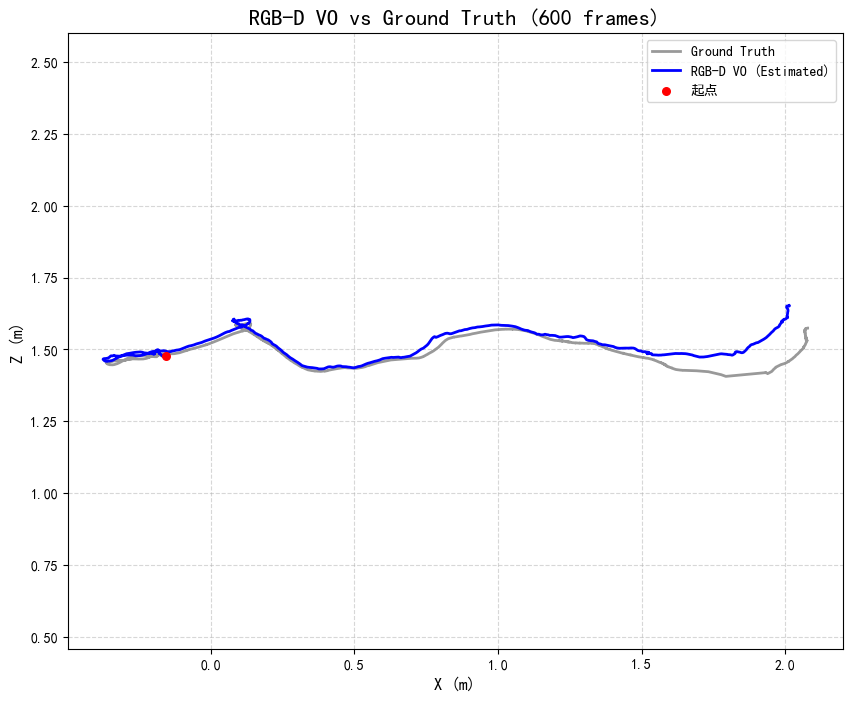

In [65]:
plot_rgbd_vs_gt(traj_rgbd, gt_dict, times)

我在实验中进行了去畸变处理，VO轨迹与GT轨迹的拟合度更高。

In [ ]:
# TODO：清理冗余代码单元格、清理注释、markdown实验分析
# plt图的标题修改、细节询问（CSV的作用？）
# 注释清理、注释补充

## RGB-D->GT 数据关联

In [85]:
# Cell: RGB-D 轨迹数据对齐、评估与导出 (最终统一格式版)

def save_and_evaluate_trajectory_unified(traj_est, rgbd_pairs, gt_dict, gt_times_list, output_filename='tum_rgbd_to_gt.csv'):
    """
    统一格式版：包含 time_diff 和 error_meters
    """
    n_frames = len(traj_est)
    # 使用与实验二相同的列名 timestamp_rgb
    est_timestamps = [pair[2] for pair in rgbd_pairs[:n_frames]]
    
    matched_data = []
    sq_errors = [] 
    
    print(f"正在对齐 {n_frames} 帧数据...")
    
    for i, t_rgb in enumerate(est_timestamps):
        # 1. 寻找最近的 GT
        t_gt = find_nearest_timestamp(t_rgb, gt_times_list)
        
        # 2. 计算时间差 (Time Diff)
        time_diff = abs(t_rgb - t_gt)
        
        # 3. 阈值过滤
        if time_diff > 0.02:
            continue
            
        # 4. 提取位置
        est_pos = traj_est[i] # [x, y, z]
        gt_data = gt_dict[t_gt] # [tx, ty, tz, qx, qy, qz, qw]
        gt_pos = gt_data[:3] # 只取位置
        
        # 5. 计算空间误差
        spatial_error = np.linalg.norm(est_pos - gt_pos)
        sq_errors.append(spatial_error ** 2)
        
        # 6. 构建统一格式的行数据
        row = {
            'timestamp_rgb': t_rgb,     # 统一命名
            'est_x': est_pos[0],
            'est_y': est_pos[1],
            'est_z': est_pos[2],
            'timestamp_gt': t_gt,
            'gt_x': gt_pos[0],
            'gt_y': gt_pos[1],
            'gt_z': gt_pos[2],
            'time_diff': time_diff, # 时间误差
            'error_meters': spatial_error # 空间误差
        }
        matched_data.append(row)
        
    # 保存与报告
    df = pd.DataFrame(matched_data)
    
    if not df.empty:
        df.to_csv(output_filename, index=False)
        print(f"对齐数据已保存至: {output_filename}")
        
        # 计算指标评估
        rmse = np.sqrt(np.mean(sq_errors))
        print(f"\n======== 最终评估报告========")
        print(f"匹配帧数: {len(df)} / {n_frames}")
        print(f"RMSE (绝对轨迹误差): {rmse:.4f} m")
        print(f"平均时间对齐误差: {df['time_diff'].mean():.6f} s")
        print(f"最大误差: {np.max(np.sqrt(sq_errors)):.4f} m")
        print(f"=====================================")
        
        print("\nCSV 格式预览:")
        print(df.head(5).to_string())
    else:
        print("未匹配到数据")

In [86]:
save_and_evaluate_trajectory_unified(traj_rgbd, rgbd_pairs, gt_dict, gt_times_list)

正在对齐 600 帧数据...
对齐数据已保存至: tum_rgbd_to_gt.csv

======== 最终评估报告========
匹配帧数: 502 / 600
RMSE (绝对轨迹误差): 0.0382 m
平均时间对齐误差: 0.002059 s
最大误差: 0.0969 m

CSV 格式预览:
   timestamp_rgb     est_x     est_y     est_z  timestamp_gt    gt_x    gt_y    gt_z  time_diff  error_meters
0   1.311868e+09 -0.154600 -1.444500  1.477300  1.311868e+09 -0.1546 -1.4445  1.4773   0.000019      0.000000
1   1.311868e+09 -0.157194 -1.443951  1.478120  1.311868e+09 -0.1578 -1.4458  1.4770   0.000774      0.002245
2   1.311868e+09 -0.160132 -1.445971  1.477602  1.311868e+09 -0.1601 -1.4472  1.4767   0.001140      0.001525
3   1.311868e+09 -0.163148 -1.450291  1.476185  1.311868e+09 -0.1633 -1.4501  1.4766   0.000145      0.000481
4   1.311868e+09 -0.165028 -1.453768  1.475966  1.311868e+09 -0.1660 -1.4525  1.4765   0.000670      0.001684


精度还是比较高的，最大误差仅为9.7厘米。

## 探索实验：双目视觉VO

从calib.txt文件中找到参数如下，KITTI已经经过校正，无畸变。

In [ ]:
K_kitti = np.array([[707.0912, 0, 601.8873],
                    [0, 707.0912, 183.1104],
                    [0, 0, 1]])
baseline_kitti = 0.537

In [89]:
# Cell 16: KITTI 数据加载与参数配置

def load_kitti_data(base_path, sequence='09'):
    """
    加载 KITTI 数据集(Image 0, Image 1, Ground Truth)
    """
    # 路径拼接
    seq_path = os.path.join(base_path, 'sequences', sequence)
    img0_path = os.path.join(seq_path, 'image_0')
    img1_path = os.path.join(seq_path, 'image_1')
    
    # 加载图片文件列表
    left_images = sorted([os.path.join(img0_path, f) for f in os.listdir(img0_path) if f.endswith('.png')])
    right_images = sorted([os.path.join(img1_path, f) for f in os.listdir(img1_path) if f.endswith('.png')])
    
    # 加载 Ground Truth (base_path/poses/09.txt)
    pose_path = os.path.join(base_path, 'poses', f'{sequence}.txt')
    gt_poses = []
    
    if os.path.exists(pose_path):
        with open(pose_path, 'r') as f:
            for line in f:
                # KITTI Pose 格式: r11 r12 r13 tx r21 ... (3x4 矩阵展平)
                val = list(map(float, line.strip().split()))
                T = np.array(val).reshape(3, 4)
                # 补齐为 4x4
                T_4x4 = np.eye(4)
                T_4x4[:3, :] = T
                gt_poses.append(T_4x4)
    else:
        print(f"Warning: GT pose file not found at {pose_path}")
        
    print(f"已加载 KITTI Sequence {sequence}: {len(left_images)} 帧图像, {len(gt_poses)} 个真值位姿")
    return left_images, right_images, gt_poses

In [90]:
kitti_root = '../data/chaoxing_data/kitti'
left_imgs, right_imgs, kitti_gt = load_kitti_data(kitti_root, '09')

已加载 KITTI Sequence 09: 1591 帧图像, 1591 个真值位姿


In [91]:
# Cell 17: 双目特征提取与 3D 点生成

def compute_stereo_3d_points(img_l, img_r, K, b):
    """
    输入: 左图, 右图, 内参, 基线
    输出: 
        keypoints_l: 左图特征点 (N, 2)
        descriptors_l: 左图描述子
        points_3d: 对应的 3D 点 (N, 3)
    """
    # 1. 提取 ORB 特征
    orb = cv2.ORB_create(nfeatures=2000)
    kp_l, des_l = orb.detectAndCompute(img_l, None)
    kp_r, des_r = orb.detectAndCompute(img_r, None)
    
    if des_l is None or des_r is None:
        return np.array([]), None, np.array([])
        
    # 2. 左右匹配
    # crossCheck=True 可以提高匹配的可靠性
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_l, des_r)
    
    # 3. 筛选与三角化
    valid_kp_l = []
    valid_des_l = []
    points_3d = []
    
    fx = K[0, 0]
    cx = K[0, 2]
    cy = K[1, 2]
    
    for m in matches:
        # 获取像素坐标
        u_l, v_l = kp_l[m.queryIdx].pt
        u_r, v_r = kp_r[m.trainIdx].pt
        
        # 因为图像已校正，匹配点应该在同一行 (v_l ≈ v_r)
        # 允许 1-2 像素的误差
        if abs(v_l - v_r) > 2.0:
            continue
            
        # 计算视差
        disparity = u_l - u_r
        
        # 过滤视差太小的点 (太远，深度不准)
        # 0.537 * 707 / 30m ≈ 12 pixels. 视差小于 10-15 意味着距离超过 30米
        if disparity < 10.0: 
            continue
            
        # 计算深度 Z = f * b / d
        z = (fx * b) / disparity
        
        # 计算 X, Y
        x = (u_l - cx) * z / fx
        y = (v_l - cy) * z / fx # 这里用 f_x 或 f_y 均可，KITTI 中它们相等
        
        points_3d.append([x, y, z])
        valid_kp_l.append(kp_l[m.queryIdx].pt)
        valid_des_l.append(des_l[m.queryIdx])
        
    return np.array(valid_kp_l), np.array(valid_des_l), np.array(points_3d)

In [92]:
# Cell 18: 双目 VO 主循环

def run_stereo_vo(left_imgs, right_imgs, K, b, gt_poses):
    trajectory = []
    
    # 初始化全局位姿
    # Trick：使用 GT 第一帧，保证和真值图对齐
    if len(gt_poses) > 0:
        T_w_c = gt_poses[0]
    else:
        T_w_c = np.eye(4)
        
    trajectory.append(T_w_c[:3, 3])
    
    # 读取第一帧并计算初始 3D 点
    prev_img_l = cv2.imread(left_imgs[0], cv2.IMREAD_GRAYSCALE)
    prev_img_r = cv2.imread(right_imgs[0], cv2.IMREAD_GRAYSCALE)
    
    # 计算上一帧的 Stereo 数据
    # prev_kp: 上一帧左图的关键点 2D
    # prev_des: 上一帧左图的描述子
    # prev_pts_3d: 上一帧左图对应的 3D 点 (在上一帧相机系下)
    prev_kp, prev_des, prev_pts_3d = compute_stereo_3d_points(prev_img_l, prev_img_r, K, b)
    
    print(f"Stereo VO 开始运行...")
    
    # 循环处理
    for i in range(1, min(len(left_imgs), 600)):
        curr_img_l = cv2.imread(left_imgs[i], cv2.IMREAD_GRAYSCALE)
        curr_img_r = cv2.imread(right_imgs[i], cv2.IMREAD_GRAYSCALE) # 当前帧的右图其实这里用不到，除非要做 Frame-to-Frame Stereo 优化
        
        # 1. 提取当前帧左图特征 (用于时间匹配)
        orb = cv2.ORB_create(nfeatures=2000)
        curr_kp_raw, curr_des_raw = orb.detectAndCompute(curr_img_l, None)
        
        if prev_des is None or curr_des_raw is None:
            continue
            
        # 2. 时间匹配 (Temporal Matching): Left(t-1) -> Left(t)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(prev_des, curr_des_raw)
        
        # 3. 构建 PnP 输入数据
        obj_pts = [] # 3D 点 (来自上一帧 Stereo)
        img_pts = [] # 2D 点 (当前帧观测)
        
        for m in matches:
            idx_prev = m.queryIdx # 上一帧的索引
            idx_curr = m.trainIdx # 当前帧的索引
            
            # 并不是所有上一帧的特征点都有 3D 坐标 (可能没匹配上右图)
            # 这里的 prev_des 是 compute_stereo_3d_points 返回的 filtered descriptors
            # 所以索引是一一对应的。prev_des[k] 对应 prev_pts_3d[k]
            
            pt_3d = prev_pts_3d[idx_prev]
            pt_2d = curr_kp_raw[idx_curr].pt
            
            obj_pts.append(pt_3d)
            img_pts.append(pt_2d)
            
        obj_pts = np.array(obj_pts)
        img_pts = np.array(img_pts)
        
        # 4. 位姿解算
        if len(obj_pts) > 10:
            # 求解 T_prev_curr (上一帧到当前帧)
            success, rvec, tvec, inliers = cv2.solvePnPRansac(
                obj_pts, img_pts, K, None, # KITTI 已校正，无畸变
                iterationsCount=100, reprojectionError=2.0
            )
            
            if success:
                R_rel, _ = cv2.Rodrigues(rvec)
                T_prev_curr = np.eye(4)
                T_prev_curr[:3, :3] = R_rel
                T_prev_curr[:3, 3] = tvec.flatten()
                
                # 更新全局位姿
                # T_w_curr = T_w_prev * (T_prev_curr)^-1
                # 这里的逻辑和 RGB-D 实验一致
                try:
                    T_curr_prev = np.linalg.inv(T_prev_curr)
                    T_w_c = T_w_c @ T_curr_prev
                except: pass
        
        trajectory.append(T_w_c[:3, 3])
        
        # 5. 更新状态 (Replenishment)
        # 双目 VO 的特点：每一帧都重新计算 Stereo，相当于完全补充了地图点
        # 我们不需要保留上一帧没匹配上的点，因为下一帧会生成新的 3D 点
        prev_kp, prev_des, prev_pts_3d = compute_stereo_3d_points(curr_img_l, curr_img_r, K, b)
        prev_img_l = curr_img_l
        
        if i % 100 == 0:
            print(f"Frame {i}: Pos {T_w_c[:3, 3]}")
            
    return np.array(trajectory)

In [93]:
traj_stereo = run_stereo_vo(left_imgs, right_imgs, K_kitti, baseline_kitti, kitti_gt)
print("Stereo VO 完成")

Stereo VO 开始运行...
Frame 100: Pos [-38.90152165  -5.06084522  70.51476648]
Frame 200: Pos [-129.33543089  -14.6769368   133.58272027]
Frame 300: Pos [-105.06651474  -23.28288596  238.93936407]
Frame 400: Pos [-17.19143857 -35.20500986 285.79881698]
Frame 500: Pos [ 22.70353738 -38.82023187 379.59878226]
Stereo VO 完成


In [100]:
# Cell 19: 双目 VO 结果可视化

def plot_kitti_trajectory(traj_est, gt_poses):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    # === 1. 动态切片 GT 数据 ===
    n_frames = len(traj_est)
    # 确保不越界
    limit = min(n_frames, len(gt_poses))
    
    # 只提取与 VO 帧数一致的 GT 数据
    gt_subset = gt_poses[:limit]
    gt_xyz = np.array([T[:3, 3] for T in gt_subset])
    
    # === 2. 绘制 ===
    # GT
    if len(gt_xyz) > 0:
        ax.plot(gt_xyz[:, 0], gt_xyz[:, 2], label='Ground Truth', color='gray', linewidth=2, alpha=0.7)
    
    # 估算
    ax.plot(traj_est[:, 0], traj_est[:, 2], label='Stereo VO (ORB)', color='blue', linewidth=2)
    
    # 标记起点
    if len(traj_est) > 0:
        ax.scatter(traj_est[0, 0], traj_est[0, 2], c='red', s=100, label='Start Point', zorder=5)
        ax.scatter(traj_est[-1, 0], traj_est[-1, 2], c='green', s=60, label='End Point', marker='x', zorder=5)

    # 计算简单的终点漂移
    if len(gt_xyz) > 0:
        final_error = np.linalg.norm(traj_est[-1] - gt_xyz[-1])
        title_str = f'KITTI Stereo VO vs GT ({n_frames} Frames)\n终点漂移: {final_error:.2f} m'
    else:
        title_str = f'KITTI Stereo VO vs GT ({n_frames} Frames)'

    ax.set_title(title_str, fontsize=16)
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Z (m)', fontsize=12)
    ax.legend()
    ax.axis('equal') # 保持比例一致
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

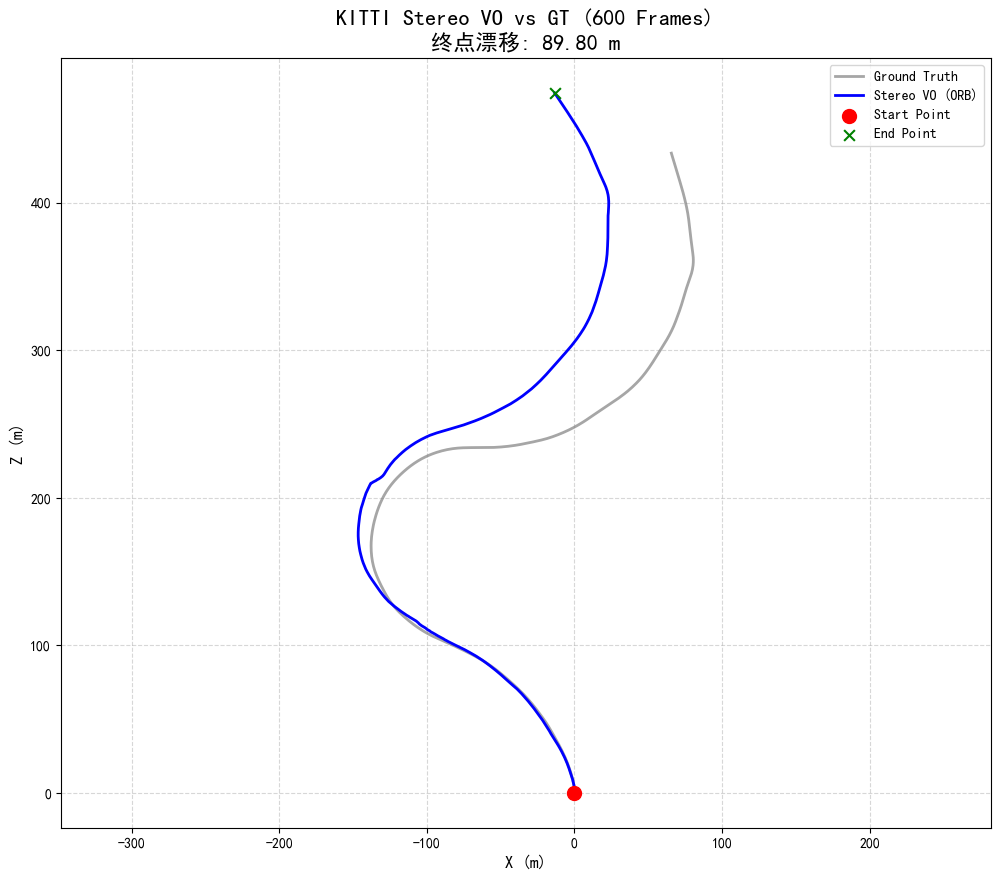

In [101]:
plot_kitti_trajectory(traj_stereo, kitti_gt)

终点漂移为89.8m.